# Importing Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connecting to data

In [7]:
account_info = pd.read_csv(r"C:\Users\USER\Desktop\da_fitly_account_info.csv")
customer_support = pd.read_csv(r"C:\Users\USER\Desktop\da_fitly_customer_support.csv")
user_activity = pd.read_csv(r"C:\Users\USER\Desktop\da_fitly_user_activity.csv")

# DATA VALIDATION & CLEANING 

In [13]:
# 1. Standardize Customer IDs to match across tables
# I stripped the 'C' from account_info and convert to integer
account_info['user_id'] = account_info['customer_id'].str.replace('C', '').astype(int)

# 2. Clean Churn Status (Convert NaN to 0 and 'Y' to 1)
account_info['churned'] = account_info['churn_status'].fillna('N').map({'Y': 1, 'N': 0})

# 3. Convert time columns to datetime objects
customer_support['ticket_time'] = pd.to_datetime(customer_support['ticket_time'])
user_activity['event_time'] = pd.to_datetime(user_activity['event_time'])

# 4. Clean Support Data
# In this dataset, 'state' in support refers to resolution status (1=Resolved, 0=Unresolved)
customer_support = customer_support.rename(columns={'state': 'is_resolved'})
customer_support['channel'] = customer_support['channel'].replace('-', 'Unknown')

# 5. Aggregate Activity & Support for a Master DataFrame
# This aligns engagement and support activity per user
user_engagement = user_activity.groupby('user_id').size().reset_index(name='total_events')
user_support = customer_support.groupby('user_id').agg(
    avg_resolution=('resolution_time_hours', 'mean'),
    ticket_count=('user_id', 'count')
).reset_index()

# Merge into a final dataset
df = account_info.merge(user_engagement, on='user_id', how='left').merge(user_support, on='user_id', how='left')
df[['total_events', 'avg_resolution', 'ticket_count']] = df[['total_events', 'avg_resolution', 'ticket_count']].fillna(0)

print("Data Validation Complete. Cleaned dataset ready for analysis.")

Data Validation Complete. Cleaned dataset ready for analysis.


# Exploratory Data Analysis (EDA)


In [14]:
# Set the visual style
sns.set_style("whitegrid")

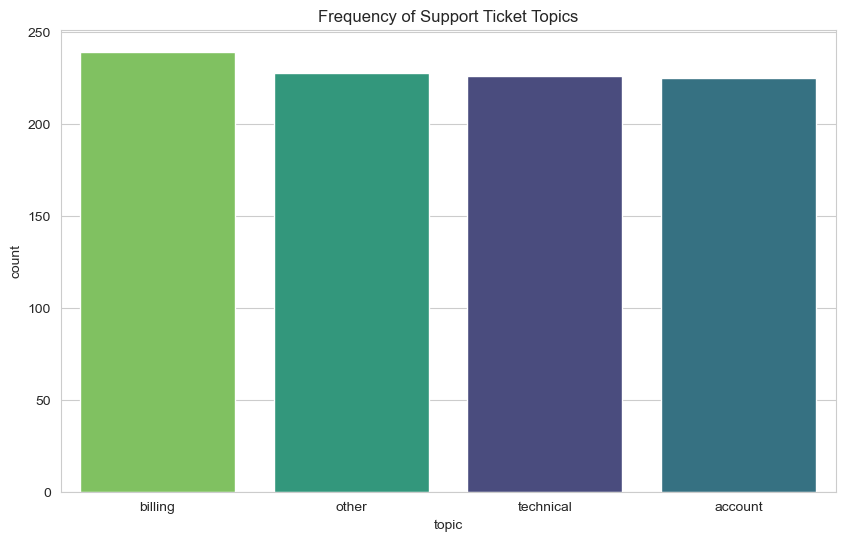

In [15]:
# Support Ticket Topics Distribution
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customer_support,
    x='topic',
    hue='topic',
    palette='viridis',
    order=customer_support['topic'].value_counts().index,
    legend=False
)
plt.title('Frequency of Support Ticket Topics')
plt.show()


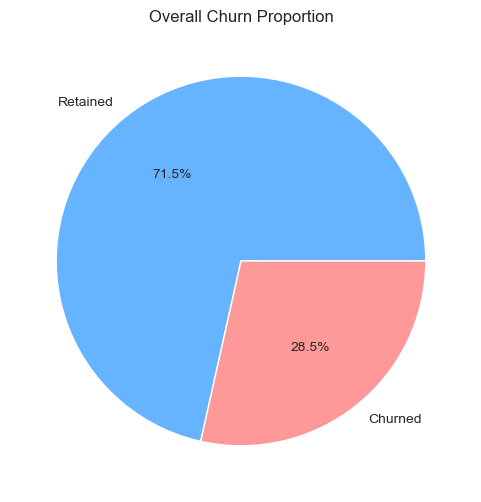

In [18]:
# Churn Distribution
plt.figure(figsize=(6, 6))
df['churned'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], labels=['Retained', 'Churned'])
plt.title('Overall Churn Proportion')
plt.ylabel('')
plt.show()


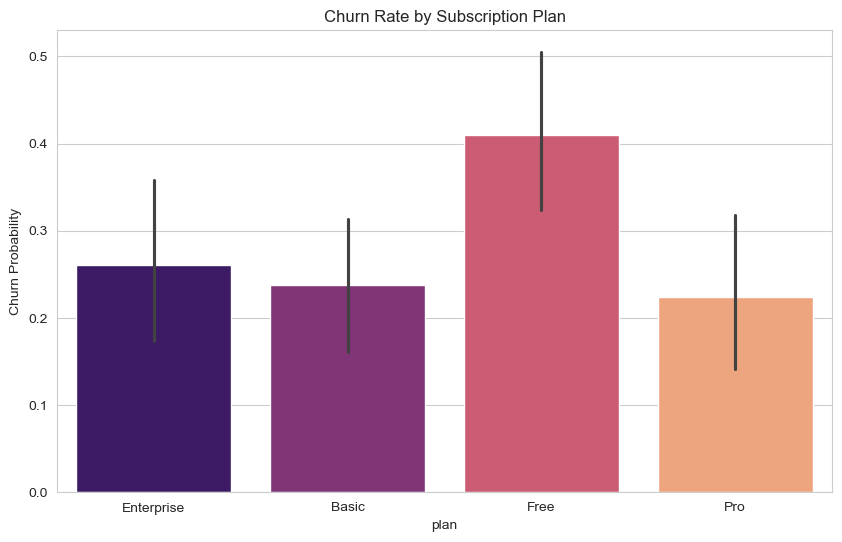

In [19]:
# Churn Rate by Plan Type
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x='plan',
    y='churned',
    hue='plan',
    palette='magma',
    legend=False
)
plt.title('Churn Rate by Subscription Plan')
plt.ylabel('Churn Probability')
plt.show()


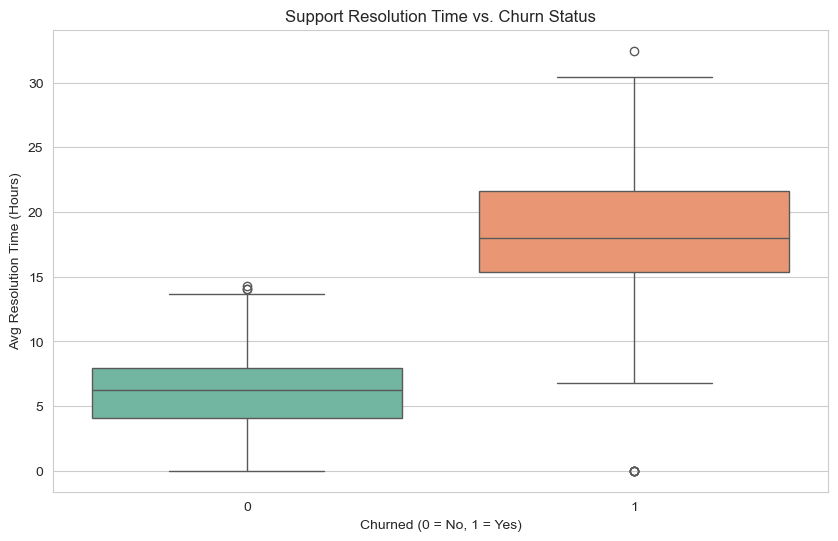

In [22]:
# Impact of Support Resolution Time on Churn
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='churned',
    y='avg_resolution',
    hue='churned',
    palette='Set2',
    legend=False
)
plt.title('Support Resolution Time vs. Churn Status')
plt.xlabel('Churned (0 = No, 1 = Yes)')
plt.ylabel('Avg Resolution Time (Hours)')
plt.show()


# KPI ESTIMATION 

In [26]:
# Calculation of Current Churn Rate
total_customers = len(df)
churned_customers = df['churned'].sum()
current_churn_rate = (churned_customers / total_customers) * 100

In [25]:
# Calculation of Activity Baseline
avg_events_retained = df[df['churned'] == 0]['total_events'].mean()
avg_events_churned = df[df['churned'] == 1]['total_events'].mean()

print(f"--- Leadership Metric Summary ---")
print(f"Current Churn Rate: {current_churn_rate:.2f}%")
print(f"Avg Events (Retained Users): {avg_events_retained:.2f}")
print(f"Avg Events (Churned Users): {avg_events_churned:.2f}")
print(f"Avg Support Wait (Retained): {df[df['churned']==0]['avg_resolution'].mean():.2f} hrs")
print(f"Avg Support Wait (Churned): {df[df['churned']==1]['avg_resolution'].mean():.2f} hrs")

--- Leadership Metric Summary ---
Current Churn Rate: 28.50%
Avg Events (Retained Users): 1.41
Avg Events (Churned Users): 0.36
Avg Support Wait (Retained): 6.01 hrs
Avg Support Wait (Churned): 17.87 hrs
